In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as color
import skimage.data as skdata
from project.algorithms.simulation import dummy_object, ptychogram, mesh, illumination_beam
from project.algorithms.utils import circ_aperture, normalize, hsv_convert
from project.algorithms.reconstruction import epie

In [2]:
# Turn off for white background/jupyter notebook
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [28]:
intensity = np.array(plt.imread('lena.tif'))
phase = skdata.camera()
obj = dummy_object(intensity=intensity, phase=phase, output_shape=(256, 256))
box_shape= (161, 161)   # the size of reconstruction box
r = 0.625
illumination = illumination_beam(box_shape, beam_radius=r)
illumination = normalize(illumination)
norm = color.Normalize(-np.pi, np.pi)
rainbow = cm.ScalarMappable(norm=norm, cmap='rainbow')
gray = cm.ScalarMappable(cmap='gray')

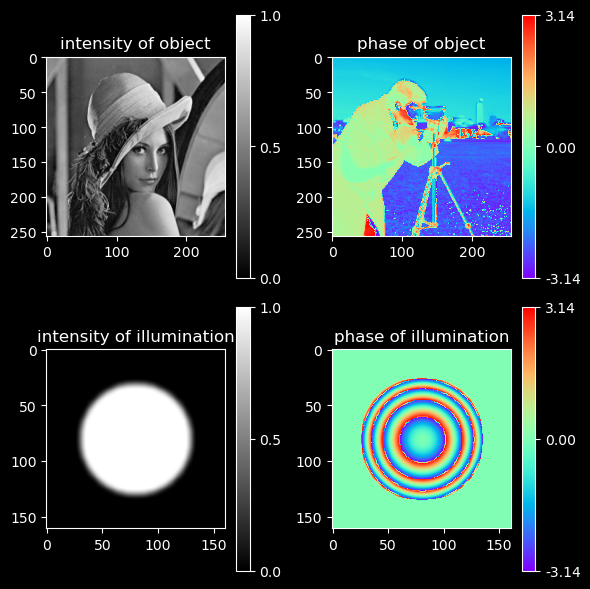

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0, 0].imshow(np.abs(obj), cmap='gray')
axes[0, 0].set_title('intensity of object')
plt.colorbar(gray, ax=axes[0, 0], ticks=[0, 0.5, 1], format='%.1f')
axes[0, 1].imshow(np.angle(obj), cmap='rainbow')
axes[0, 1].set_title('phase of object')
plt.colorbar(rainbow, ax=axes[0, 1], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[1, 0].imshow(np.abs(illumination), cmap='gray')
axes[1, 0].set_title('intensity of illumination')
plt.colorbar(gray, ax=axes[1, 0], ticks=[0, 0.5, 1], format='%.1f')
axes[1, 1].imshow(np.angle(illumination), cmap='rainbow')
plt.colorbar(rainbow, ax=axes[1, 1], ticks=[-np.pi, 0, np.pi], format='%.2f')
axes[1, 1].set_title('phase of illumination')
plt.tight_layout()

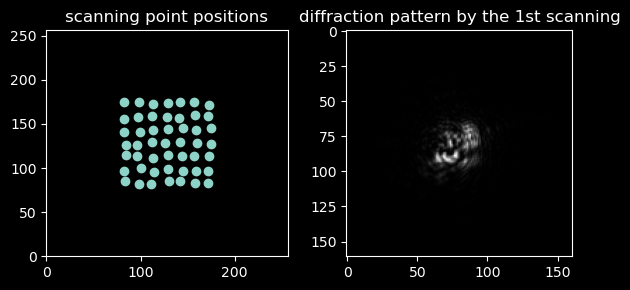

In [30]:
positions = mesh((256, 256), 50, 0.85, 7, error=2)
patterns = []
for position in positions:
    pattern = ptychogram(obj, illumination, position)
    patterns.append(pattern)
fig, axes = plt.subplots(1,2,figsize=(6,3))
axes[0].scatter(*np.transpose(positions))
axes[0].set_title('scanning point positions')
axes[0].set_xlim(0, 256)
axes[0].set_ylim(0, 256)
axes[1].imshow(patterns[0], cmap='gray')
axes[1].set_title('diffraction pattern by the 1st scanning')
plt.tight_layout()

In [33]:
guess_probe = circ_aperture(box_shape, radius=0.4)*(1+0j)
# guess_position = mesh((128, 128), 30, 0.85, 7, error=False)
guess_position = positions
recon_obj, rencon_probe, loss = epie(patterns, guess_position, (256, 256), guess_probe=guess_probe, track_error=True, n_iter=300)

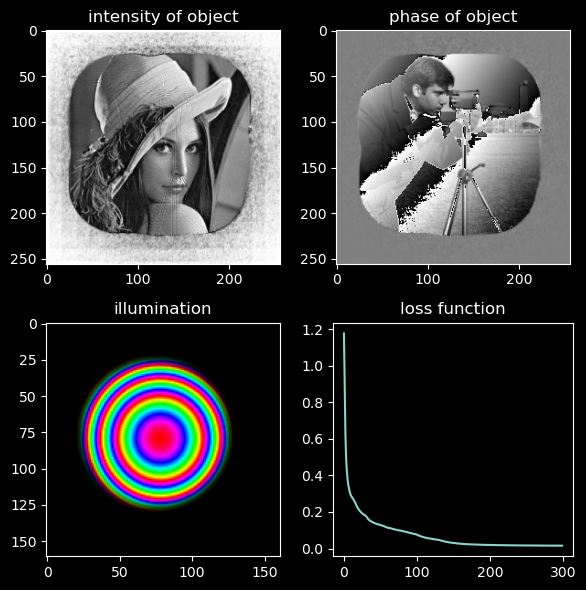

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0, 0].imshow(np.abs(recon_obj), cmap='gray')
axes[0, 0].set_title('intensity of object')
# plt.colorbar(gray, ax=axes[0, 0], ticks=[0, 0.5, 1], format='%.1f')
axes[0, 1].imshow(np.angle(recon_obj), cmap='gray', vmin=-np.pi, vmax=np.pi)
axes[0, 1].set_title('phase of object')
# plt.colorbar(rainbow, ax=axes[0, 1], ticks=[-np.pi, 0, np.pi], format='%.2f')
hsv_probe = hsv_convert(rencon_probe)
axes[1, 0].imshow(hsv_probe)
axes[1, 0].set_title('illumination')
axes[1, 1].plot(loss)
axes[1, 1].set_title('loss function')
# axes[1, 1].set_ylim(0.005, 0.2)
plt.tight_layout()

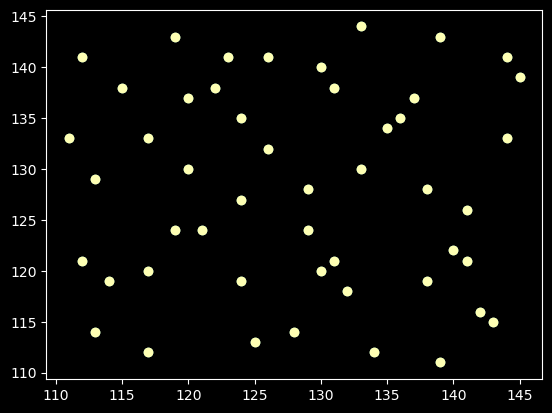

In [22]:
plt.scatter(*np.transpose(guess_position))
plt.scatter(*np.transpose(positions))

In [14]:
# np.save('positions.npy', positions)